# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023
***

# Imports
## Import des packages

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


import tools
cm = 1./2.54


## Reload module (for updates)

In [2]:
import importlib
cm = 1./2.54
importlib.reload(tools) # re-import package après changement
tools.set_theme( white_font=True ) # réglage des paramètres graphiques communs

## Lectures des différentes catégories

In [3]:
with open('openfood_OC.csv' , 'r') as file:
    categories_0 = file.readline()[:-1].split('\t')
print('{:} categories'.format(len(categories_0)))
print('categories:', categories_0 )

191 categories
categories: ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_

## Définitions keys to keep

In [4]:
# keywords for categories that must be kept
keep_keys = '|'.join( ['nutriscore', 'labels'] )
# keywords for categories that must be dropped
drop_keys = '|'.join( ['image', 'brand', 'url', 'packaging', 'emb_code', 
                        'cities', 'purchase', 'stores' , 'serving', 'states',
                        'creator', 'created'] )

categories = pd.Series( categories_0 )[~pd.Series( categories_0 ).str.contains( drop_keys ) ]
# del drop_keys

## Chargement des données
- Pour tout string -> lower
- sauvegarde avec pickle pour recharge plus rapide

In [5]:
data = pd.DataFrame()

# CATEGORY TO BE SET LATER
# dtypes = { key:'category' for key in ['nova_group', 'nutriscore_grade'] }

dtypes = {}
for key in ['code', 'traces', 'traces_en', 'traces_tags',
            'origins_en', 'origins_tags', 'purchase_places',
            'manufacturing_places', 'manufacturing_places_tags',
            'origins', 'food_groups_tags','ingredients_from_palm_oil_tags',
            'ingredients_that_may_be_from_palm_oil_tags',
            'emb_codes_tags', 'food_groups', 'food_groups_en',
            'cities_tags', 'ecoscore_grade_fr', 'emb_codes',
            'allergens', 'additives',
            'nova_group', 'nutriscore_grade'
            ]:
    dtypes[key]= 'object'

if False:
    # load data to DataFrame
    data = pd.read_csv( 'openfood_OC.csv', delimiter='\t', usecols=categories, dtype=dtypes )
    
    # lower all string except grade
    for key in data.keys():
        if data[key].dtype == 'object':
            if 'grade' in key.__str__(): # upper for nutriscore_grade
                data[key] = data[key].str.upper()
            else:
                data[key] = data[key].str.lower()
        
    # Save to compressed format for faster reload
    data.to_pickle( 'data0.pkl')
else:
    data = pd.read_pickle( 'data0.pkl' )

In [6]:
data.shape

(800000, 162)

***
# Gestion des doublons

## Détection et gestion des doublons
* doublons complets: <span style="color:orange"> $\rightarrow$ pas de doublon complet sur ce jeu de données </span>

1. code: <span style="color:orange">  prendre le plus récent ou le plus complet si même date </span>
2. si même date: <span style="color:orange"> prendre le plus complet </span>

In [7]:
duplicated_codes = data['code'].duplicated(keep=False)

# DataFrame avec les 'codes' en double
df_tmp = data.loc[duplicated_codes, :].copy()
# calcul du nombre de colonnes remplies (non NaN)
df_tmp['n filled'] = len(data.keys()) - df_tmp.isnull().sum(1)
# tri des valeurs pour trier
df_tmp.sort_values( by=['code', 'last_modified_datetime', 'n filled'] , inplace=True )

print('DataFrame of the duplicated rows (code)')
display( df_tmp[ ['code', 'last_modified_datetime', 'n filled'] ] )

# indexes des doublons à enlever
indexes_to_drop = df_tmp.index[::2] 


if len(indexes_to_drop) > 0:
    print('indexes of rows to drop:', indexes_to_drop )
    data.drop( index= df_tmp.index[::2] , inplace=True )
else:
    print('no row to drop')

del df_tmp, indexes_to_drop

DataFrame of the duplicated rows (code)


,code,last_modified_datetime,n filled
421527,31843340000818,2021-08-17t06:35:03z,28
349035,31843340000818,2022-02-11t08:47:36z,30
61995,3560070278831,2021-04-17t07:44:17z,41
188851,3560070278831,2022-02-10t18:03:06z,47
270028,3700320230572,2021-08-24t12:58:09z,16
749882,3700320230572,2021-08-24t12:58:58z,33
480000,7071688002962,2021-07-13t14:26:35z,40
477267,7071688002962,2021-07-13t14:26:35z,45


indexes of rows to drop: Int64Index([421527, 61995, 270028, 480000], dtype='int64')


***
# Données utiles
## Décompte des NaN
Les NaN sont comptés une fois et gardés en mémoire dans un DataFrame

In [8]:
n = len(data) # number of samples
data_isna = data.isna()
df_croisement = {}

***
# Filtrage par mots-clefs

## Colonnes non-chargées
Décompte des colonnes non-chargées car non utiles pour l'étude actuelle.

In [9]:
categories_non_chargees = pd.Series( categories_0 )[pd.Series( categories_0 ).str.contains( drop_keys ) ]
print('{:} colonnes non chargées sur {:}'.format( len(categories_non_chargees), len(categories_0) ) )

29 colonnes non chargées sur 191


## Vendu en France ?
Pour l'application choisie, on ne s'intéresse qu'aux produits vendus en France.

Un tableau est dressé pour vérifier si des NaN "contry" peuvent être remplis depuis d'autres variables.
Pour les données analysées ici, ce n'est pas le cas.

In [10]:
keys = data.keys()[ data.keys().str.contains('countr') ]
display( 'Keys linked to countries:', keys.tolist() )

display( 'Sum ina:', data_isna[keys].sum(0) )

df_croisement = {}
df_croisement['countries'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN countries:')
display( df_croisement['countries'] )

# display( data.loc[ ~data_isna['countries'] & data_isna['countries_tags'] , keys])

target_country = 'france'
contains_france = { key: data[key].str.contains( target_country ) for key in keys }


contains_france = { key: data[key].str.contains( target_country ) for key in keys }
sr_country_ok = contains_france['countries'] | contains_france['countries_tags'] | contains_france['countries_en']

print('number of row containing france in:')
for key in keys:
    print( '{:}: {:}'.format( key, contains_france[key].sum() ) ) 
print( 'countries | countries_tags:', (contains_france['countries'] | contains_france['countries_tags'] ).sum() ) 
print( 'countries | countries_en:', (contains_france['countries'] | contains_france['countries_en'] ).sum() ) 
print( 'any of the three:', sr_country_ok.sum() ) 

'Keys linked to countries:'

['countries', 'countries_tags', 'countries_en']

'Sum ina:'

countries         2300
countries_tags    2301
countries_en      2301
dtype: int64

Croisement NaN countries:


~isna \ isna,countries,countries_tags,countries_en
countries,0,1,1
countries_tags,0,0,0
countries_en,0,0,0


number of row containing france in:
countries: 216447
countries_tags: 321629
countries_en: 321629
countries | countries_tags: 321630
countries | countries_en: 321630
any of the three: 321630


Le filtre/masque est appliqué et les colonnes (maintenant) inutiles sont abandonnées.

In [11]:
# keep only data of the target country
data.drop( data.index[ ~sr_country_ok ] , inplace=True ) 
data_isna.drop( data_isna.index[ ~sr_country_ok ] , inplace=True )

if True: 
    data.drop( columns=keys, inplace=True )
    data_isna.drop( columns=keys, inplace=True )

# data = data.reset_index()
# data_isna = data_isna.reset_index()
del sr_country_ok, contains_france

# Suppression des colonnes vides

In [12]:
n_filled = len(data) - data_isna.sum(0)
empty_columns = n_filled[n_filled==0]
n_to_drop = len(empty_columns)
print('{:} colonnes supprimée sur {:}, reste {:}'.format( n_to_drop, len(n_filled), len(n_filled)-n_to_drop  ) )
print('Empty columns:',  empty_columns.index.tolist() )
data.drop( columns=empty_columns.index, inplace=True)
data_isna.drop( columns=empty_columns.index, inplace=True)

39 colonnes supprimée sur 159, reste 120
Empty columns: ['allergens_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'water-hardness_100g']


***
# Gestion des valeurs aberrantes
## variables _100g "unique"
Affichage des données statistiques de bases pour chaque variable contenant "_100g"

In [13]:
keys = data.keys()[ data.keys().str.contains('_100g') ]
# print( 'Keys _100g:', keys.tolist() )
display( data[keys].describe().round(2).loc[ ['mean', 'min', '25%', '50%', '75%','max'],:])

,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
mean,1089.66,277.35,1155.24,501.36,14.22,5.64,20.59,9.47,3.74,16.91,42.10,0.12,0.08,27.38,13.62,32.43,51.96,3.11,2.11,5.0,8.89,2.86,7.41,8.35,1.30,0.52,5.33,7.3,0.02,0.07,0.24,0.00,0.18,0.2,0.27,0.34,0.3,0.34,2.42,0.02,0.69,0.05,0.08,2.41,2.07,9.87,0.70,0.48,0.07,1.06,0.34,0.02,0.01,0.01,0.4,0.0,0.42,0.35,584.80,313.55,6.74,36.23,8.5,46.01,12.3,15.08,50.94,1.58,281.50,541.09,9.42,22.0,39.35,0.09,1.18,2.73,0.03,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.10,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.87,0.00,0.0,0.00,0.0,10.00,0.00,1.58,0.00,0.98,-15.00,22.0,30.00,0.01,0.00,0.40,0.00,0.01
25%,432.00,111.00,464.00,21.00,1.00,0.20,2.00,1.50,0.47,1.10,11.25,0.00,0.00,2.60,0.60,9.70,7.00,0.10,0.00,0.0,1.50,1.04,0.23,0.02,0.06,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.08,0.00,0.03,0.13,0.00,0.03,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.02,0.04,6.02,0.00,0.0,16.80,0.0,15.00,32.00,1.58,0.00,102.81,2.00,22.0,34.67,0.07,0.00,1.78,0.02,0.01
50%,987.00,264.00,1096.00,174.00,8.00,2.00,8.93,4.00,1.70,7.75,46.00,0.00,0.00,14.00,3.40,35.95,37.00,1.70,1.00,2.0,6.20,2.90,0.55,2.80,0.53,0.21,0.00,0.0,0.00,0.00,0.01,0.00,0.01,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.20,0.02,0.12,0.23,0.00,0.08,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.03,0.10,7.20,25.00,0.0,50.00,0.0,15.00,52.00,1.58,130.00,312.00,10.00,22.0,39.35,0.09,0.00,2.60,0.03,0.01
75%,1620.00,401.00,1674.00,460.00,22.00,8.00,27.00,10.00,3.30,24.48,62.55,0.00,0.00,52.00,19.10,50.00,71.03,3.70,3.75,7.0,12.92,4.50,5.80,10.15,1.30,0.52,6.70,0.0,0.00,0.00,0.01,0.00,0.02,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.31,0.48,0.08,0.20,0.35,0.01,0.15,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.07,0.40,7.50,60.00,0.0,64.00,8.0,15.00,70.00,1.58,356.25,606.80,16.00,22.0,44.03,0.12,0.00,3.62,0.03,0.02
max,24000.00,15642.86,65450.00,3630.00,1000.00,55688.00,87.00,76.00,105.00,71.00,100.00,90.00,32.00,88888.00,8888.00,87.50,2500.00,885.00,11.00,45.8,360.00,7.40,70.00,41.00,2500.00,1000.00,135.00,7500.0,0.26,12.00,90.00,0.02,87.00,45.0,100.00,69.00,100.0,80.00,213.00,2.20,100.00,7.40,1.50,100.00,696.00,1560.00,282.00,127.00,26.00,333.33,93.92,0.40,0.80,0.50,20.0,0.0,8.30,29.00,38000.00,10000.00,8.00,100.00,100.0,100.00,13461.0,25.00,100.00,1.58,2720.00,10740.00,37.00,22.0,48.70,0.16,11.80,5.30,0.08,0.57


Bornage des valeurs (min / max) pour chaque variable contenant "_100g"
- général: valeurs < 0 ou valeurs > 100 -> NaN
- nutriscore: valeurs < -15 ou valeurs > 40 -> NaN
- ph: valeurs < 0 ou valeurs > 14
- energy: valeurs < 0 ou valeurs > 3700 -> NaN (valeur maximale en kJ) 

In [14]:
for key in keys:
    if 'carbon-footprint' in key: continue # variable non utilisée ici
    # valeurs min et max selon les variables
    if 'energy' in key: vmin,vmax = 0., 3700.
    elif 'ph' in key: vmin,vmax = 0., 14.
    elif 'nutri' in key: vmin,vmax = -15., 40.
    else: vmin,vmax = 0., 100.
    # bornage
    sr_loc = (data[key] < vmin) | (data[key] > vmax)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

# Affichage pour vérification
display( data[keys].describe().round(2).loc[ ['count','mean', 'min', '25%', '50%', '75%','max'],:])

,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,31432.00,240088.00,246640.0,53.00,246787.00,248416.00,1199.00,1210.00,514.00,104.00,18.00,1338.00,1371.00,246791.00,248324.00,108.00,287.00,61161.00,62.00,55.0,247515.00,18.00,19.00,11.00,238315.00,238325.00,4188.00,1275.00,11.00,622.00,694.00,89.00,1879.00,881.0,678.00,692.00,770.0,572.00,87.00,648.00,177.00,387.00,34.00,76.00,1021.00,159.00,3142.00,641.00,1986.00,924.00,370.00,144.00,157.00,80.00,129.0,19.0,20.00,162.00,64.00,31.00,42.00,2471.00,267.0,3855.00,95412.00,93.00,1688.00,1.00,98.00,4380.00,117089.00,1.0,2.00,20.00,10.00,6.00,17.00,13.00
mean,1086.08,277.08,1125.0,501.36,14.21,5.41,20.59,9.47,3.54,16.91,42.10,0.12,0.08,27.02,13.58,32.43,43.43,3.09,2.11,5.0,8.89,2.86,7.41,8.35,1.26,0.51,5.29,0.12,0.02,0.07,0.24,0.00,0.18,0.2,0.27,0.34,0.3,0.34,0.00,0.02,0.69,0.05,0.08,2.41,0.49,0.12,0.41,0.28,0.07,0.32,0.34,0.02,0.01,0.01,0.4,0.0,0.42,0.35,0.19,1.52,6.74,36.23,8.5,46.01,11.47,15.08,50.94,1.58,281.50,541.09,9.42,22.0,39.35,0.09,1.18,2.73,0.03,0.05
min,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.87,0.00,0.0,0.00,0.00,10.00,0.00,1.58,0.00,0.98,-15.00,22.0,30.00,0.01,0.00,0.40,0.00,0.01
25%,432.00,111.00,460.0,21.00,1.00,0.20,2.00,1.50,0.47,1.10,11.25,0.00,0.00,2.60,0.60,9.70,7.00,0.10,0.00,0.0,1.50,1.04,0.23,0.02,0.06,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.07,0.00,0.03,0.13,0.00,0.03,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.02,0.04,6.02,0.00,0.0,16.80,0.00,15.00,32.00,1.58,0.00,102.81,2.00,22.0,34.67,0.07,0.00,1.78,0.02,0.01
50%,986.00,264.00,1084.0,174.00,8.00,2.00,8.93,4.00,1.70,7.75,46.00,0.00,0.00,14.00,3.40,35.95,37.00,1.70,1.00,2.0,6.20,2.90,0.55,2.80,0.53,0.21,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.19,0.02,0.12,0.23,0.00,0.08,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.03,0.04,7.20,25.00,0.0,50.00,0.00,15.00,52.00,1.58,130.00,312.00,10.00,22.0,39.35,0.09,0.00,2.60,0.03,0.01
75%,1618.00,401.00,1663.0,460.00,22.00,8.00,27.00,10.00,3.30,24.48,62.55,0.00,0.00,52.00,19.10,50.00,71.00,3.70,3.75,7.0,12.91,4.50,5.80,10.15,1.30,0.52,6.70,0.00,0.00,0.00,0.01,0.00,0.02,0.0,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.31,0.48,0.08,0.20,0.35,0.01,0.15,0.01,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.06,0.40,7.50,60.00,0.0,64.00,7.90,15.00,70.00,1.58,356.25,606.80,16.00,22.0,44.03,0.12,0.00,3.62,0.03,0.02
max,3700.00,3700.00,3700.0,3630.00,100.00,100.00,87.00,76

## Variables connexes
- Certaines variables sont liées, et doivent respecter une comparaison
- On peut se poser la question de l'intérêt de remplacer des NaN dans les variables `keymax` par la valeur de la variable `keymin`, mais les données seraient "incomplètes"

In [15]:
for keymax,keymin in [ ('salt','sodium'), ('carbohydrates','sugars') ]:
    keymax,keymin = keymax + '_100g',keymin + '_100g'
    sr_loc = data[keymax] < data[keymin]
    data.loc[ sr_loc , keys ] = np.nan
    data_isna.loc[ sr_loc, keys ] = True
    
    display( tools.croisement_NaN_counts( data_isna, [keymax,keymin] ) )

    # certaines valeurs NaN sont remplacées par des 0.
    sr_loc = data[keymax]==0.
    data.loc[ sr_loc , keymin ] = 0.
    data_isna.loc[ sr_loc, keymin ] = False

    display( tools.croisement_NaN_counts( data_isna, [keymax,keymin] ) )


~isna \ isna,salt_100g,sodium_100g
salt_100g,0,0
sodium_100g,10,0


~isna \ isna,salt_100g,sodium_100g
salt_100g,0,0
sodium_100g,10,0


~isna \ isna,carbohydrates_100g,sugars_100g
carbohydrates_100g,0,769
sugars_100g,2302,0


~isna \ isna,carbohydrates_100g,sugars_100g
carbohydrates_100g,0,658
sugars_100g,2302,0


- Pour les `fats`, on vérifie que fat est bien la variable la plus grande parmis plusieurs
- On peut aussi se poser la question de remplir la variable `fat` à partir de `saturated-fat`, mais les données seraient "incomplètes"

In [16]:
keys = data.keys()[ data.keys().str.contains('fat') & ~data.keys().str.contains('energy') ]
print( 'Keys linked to fat:', keys.tolist() )

# set rows to NaN if fat_100g is not the maximum value
sr_loc = data[keys].fillna(0.).idxmax( 1 ) != 'fat_100g'

data.loc[ sr_loc, keys ] = np.nan
data_isna.loc[ sr_loc, keys ] = True

print('Number of data removed on fats: {:} / {:}'.format( sr_loc.sum(), len(sr_loc) ) )

df_croisement['fat'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN fat:')
display( df_croisement['fat'] )

Keys linked to fat: ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g']
Number of data removed on fats: 854 / 321630
Croisement NaN fat:


~isna \ isna,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,omega-9-fat_100g,trans-fat_100g
fat_100g,0,1155,245335,245325,246016,246419,246503,245196
saturated-fat_100g,2051,0,246234,246223,246913,247316,247399,246094
monounsaturated-fat_100g,0,3,0,26,1010,1118,1177,848
polyunsaturated-fat_100g,0,2,36,0,1005,1127,1187,862
omega-3-fat_100g,0,1,329,314,0,417,494,488
omega-6-fat_100g,0,1,34,33,14,0,89,88
omega-9-fat_100g,0,0,9,9,7,5,0,16
trans-fat_100g,0,2,987,991,1308,1311,1323,0


***
# Remplissage avec données dans colonnes voisines
## Nom produit

In [17]:
keys = data.keys()[ data.keys().str.contains('name') ]
print( 'Keys linked to name:', keys.tolist() )

n_product_name_isna = data_isna[keys].sum(0)
print( 'len(data):', len(data) )
display( 'Sum ina:', n_product_name_isna )

df_croisement['name'] = tools.croisement_NaN_counts( data_isna, keys )
print('Croisement NaN name:')
display( df_croisement['name'] )
print( tools.df2ltx(df_croisement['name'], keys_replace_indexes={'_':' '}))

Keys linked to name: ['product_name', 'abbreviated_product_name', 'generic_name']
len(data): 321630


'Sum ina:'

product_name                  8576
abbreviated_product_name    318772
generic_name                291021
dtype: int64

Croisement NaN name:


~isna \ isna,product_name,abbreviated_product_name,generic_name
product_name,0,310337,282502
abbreviated_product_name,141,0,344
generic_name,57,28095,0


\begin{tabular}{cccc}
	\rowcolor{dfFirstRow}
	 & product name & abbreviated product name & generic name \tabularnewline
	\rowcolor{dfEvenRow}
	product name & 0 & 310337 & 282502 \tabularnewline
	\rowcolor{dfOddRow}
	abbreviated product name & 141 & 0 & 344 \tabularnewline
	\rowcolor{dfEvenRow}
	generic name & 57 & 28095 & 0
\end{tabular}


Les `product_name` sont partiellements remplis avec `generic_name` ou `abbreviated_product_name`

In [18]:
sr_loc = data_isna['product_name'] & ~data_isna['abbreviated_product_name']
data.loc[ sr_loc , ['product_name'] ] = data['abbreviated_product_name']
data_isna.loc[ sr_loc, 'product_name'] = False

sr_loc = data_isna['product_name'] & ~data_isna['generic_name']
data.loc[ sr_loc , ['product_name'] ] = data['generic_name']
data_isna.loc[ sr_loc, 'product_name'] = False


del sr_loc

df_croisement['name'] = tools.croisement_NaN_counts( data_isna, keys )

print( 'nombre de NaN remplacés:', n_product_name_isna['product_name'] - data_isna['product_name'].sum(0) )
print('\nCroisement NaN name:')
display( df_croisement['name'] )

nombre de NaN remplacés: 185

Croisement NaN name:


~isna \ isna,product_name,abbreviated_product_name,generic_name
product_name,0,310381,282630
abbreviated_product_name,0,0,344
generic_name,0,28095,0


Les valeurs nulles et les colonnes qui ne sont plus utiles sont abandonnées.

In [19]:
# keep only data of with a product_name
data.drop( data.index[ data_isna['product_name'] ] , inplace=True ) 
data_isna.drop( data_isna.index[ data_isna['product_name'] ] , inplace=True )

keys_to_drop = keys[ keys != 'product_name' ]
data.drop( columns=keys_to_drop.values, inplace=True )
data_isna.drop( columns=keys_to_drop.values, inplace=True )

## Catégories
### Adaptation des valeur et tableau de croisement NaN initial
Quelques valeurs doivent être adaptées.
- principalement pnns_groups: unknown -> NaN
- food_groups: "en:"->"" & '-'->' '

In [20]:
keys = data.keys()[ (data.keys().str.contains('group|catego')) & ~(data.keys().str.contains('nova')) ]
print( 'Keys linked to group/category:', keys.tolist() )


if False: # non utilisé ici
    # replace "en:" and "-" in food_groups to improve readability
    data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
    data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )

# replace 'unknown' to NaN
data.replace( {key:'unknown' for key in keys }, np.nan, inplace=True )

data_isna[keys] = data[keys].isna()



print( '\nSum ina:')
print( data_isna[keys].sum(0) )


df_croisement['category'] = tools.croisement_NaN_counts( data_isna, keys )

print('\nCroisement NaN category:')
display( df_croisement['category'] )

# display( data.loc[ data_isna['pnns_groups_1'] , ['product_name', 'generic_name'] ] )

Keys linked to group/category: ['categories', 'categories_tags', 'categories_en', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'main_category', 'main_category_en']

Sum ina:
categories          161334
categories_tags     161335
categories_en       161335
pnns_groups_1       179241
pnns_groups_2       179241
food_groups         179017
food_groups_tags    179017
food_groups_en      179045
main_category       161335
main_category_en    161335
dtype: int64

Croisement NaN category:


~isna \ isna,categories,categories_tags,categories_en,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,main_category,main_category_en
categories,0,1,1,17907,17907,17683,17683,17711,1,1
categories_tags,0,0,0,17906,17906,17682,17682,17710,0,0
categories_en,0,0,0,17906,17906,17682,17682,17710,0,0
pnns_groups_1,0,0,0,0,0,20,20,20,0,0
pnns_groups_2,0,0,0,0,0,20,20,20,0,0
food_groups,0,0,0,244,244,0,0,28,0,0
food_groups_tags,0,0,0,244,244,0,0,28,0,0
food_groups_en,0,0,0,216,216,0,0,0,0,0
main_category,0,0,0,17906,17906,17682,17682,17710,0,0
main_category_en,0,0,0,17906,17906,17682,17682,17710,0,0


### Remplissage pnns_groups_1
Création et vérification de la pertinence du mapping

data chi: 313239

Before process:
nan in data_chi:
pnns_groups_1    179241
pnns_groups_2    179241
food_groups      179017
main_category    161335
dtype: int64


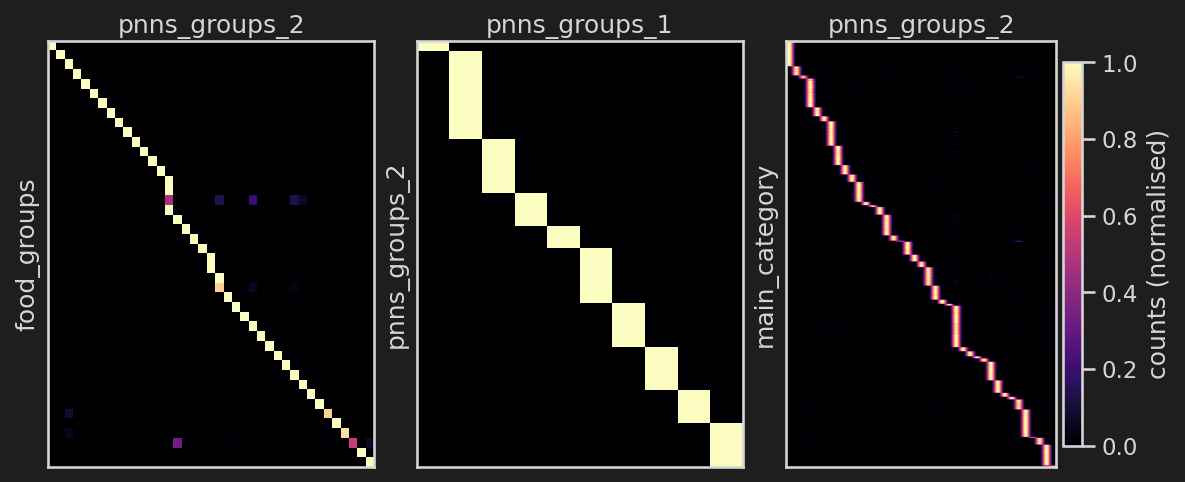

In [21]:
keys = ['pnns_groups_1', 'pnns_groups_2', 'food_groups', 'main_category']
data_chi = data[keys].copy()

n_isna_data_chi = data_chi.isna().sum()
print('data chi:', len(data_chi))
print('\nBefore process:\nnan in data_chi:')
print( n_isna_data_chi )

data_chi_isna = data_chi.isna()



type_plot = ['xi', 'count'][1] # type de valeurs affichées sur les images

# paires de colonnes pour calculcer les mapping
X1, Y1 = 'food_groups', 'pnns_groups_2'
X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X3, Y3 = 'main_category', 'pnns_groups_2'
X4, Y4 = 'main_category', 'food_groups'

maps = [ ] # pour les différentes maps
fig, axs = plt.subplots( 1,3, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) , (X3,Y3)]): #, (X4,Y4) ] ):
    xi_ij, contingences = tools.chi2( data_chi.drop( 
                        data_chi.index[ data_chi_isna[[X,Y]].sum(1) > 0 ] ),
                            X, Y )

    image = contingences.values # nombre des valeurs
    image = image[:-1,:-1] / image[:-1,-1:] # normalisation par la somme par ligne
    argmax_col = image.argmax(1) # indices des maxima par ligne
    maps.append( pd.Series( { key_in:contingences.keys()[imax_col] 
                    for key_in, imax_col 
                    in zip(contingences[:-1].index, argmax_col)} ) )
    argsort_rows = argmax_col.argsort() # tri pour améliorer l'affichage
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    # affichage du tableau de contingence
    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    if i+1 == len(axs):
        cb = plt.colorbar( im, ax=axs[i], pad=0.02,
                        shrink=[0.9, 0.9, 0.9, 0.9][i], 
                        label=label)
    axs[i].set_xlabel(Y)
    axs[i].set_ylabel(X)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

fig.tight_layout( pad=0.4 )

tools.savefig( fig, 'Figures/groups_mapping')

Application du mapping

In [22]:
# Différentes valeurs de pnns_groups_1
keys_pnns_groups_1 = data['pnns_groups_1'].value_counts().keys()
sr_pnns_groups_1 = pd.Series( {key:key for key in keys_pnns_groups_1 } )

# initialisation du mapping (food_groups to pnns_groups_1)
food_to_pnns_groups = pd.Series({key:np.nan for key in data['food_groups'].value_counts().index})
# clefs qui sont dans le mapping et le sr_pnns_groups_1
sr_in = pd.Series( [index in food_to_pnns_groups.index for index in sr_pnns_groups_1.index] )

# remplissage du mapping
food_to_pnns_groups.loc[maps[0].index] = maps[1][maps[0].values].values
food_to_pnns_groups = pd.concat( (food_to_pnns_groups, sr_pnns_groups_1[(~sr_in).values]) )
food_to_pnns_groups[ sr_pnns_groups_1[sr_in.values].index ] = sr_pnns_groups_1[sr_in.values].values

# application du mapping
b_map = data_chi_isna['pnns_groups_1'] & ~data_chi_isna['food_groups']
data.loc[b_map, 'pnns_groups_1'] = data.loc[b_map,'food_groups'].map( food_to_pnns_groups )




# initialisation du mapping (main_category to pnns_groups_1)
categories_to_pnns_groups = pd.concat( ( pd.Series({key:np.nan for key in data['main_category'].value_counts().index}) ,
                pd.Series( {key:key for key in keys_pnns_groups_1 } ) ) )

# idem plus haut
categories_to_pnns_groups.loc[maps[2].index] = maps[1][maps[2].values].values

b_map = data_chi_isna['pnns_groups_1'] & ~data_chi_isna['main_category']


data.loc[b_map, 'pnns_groups_1'] = data.loc[b_map,'main_category'].map( categories_to_pnns_groups )
# data.loc[b_map, 'pnns_groups_1'] = categories_to_pnns_groups[ data.loc[b_map,'main_category'].values ].values




data_isna[keys] = data[keys].isna()

# check remplissage

print('NaN remplacé dans pnns_groups_1: {:} / {:}'.format( 
            n_isna_data_chi['pnns_groups_1'] - data_isna['pnns_groups_1'].sum(),
            n_isna_data_chi['pnns_groups_1']) )

del image, cb, im, axs, fig
del X1,Y1, X2,Y2, X3,Y3, maps

NaN remplacé dans pnns_groups_1: 9401 / 179241


- Vérification du tableau des contingence des NaN: il reste des valeurs non-NaN dans food_groups et main_category, mais sans valeur équivalente connue pour pnns_groups dans l'échantillon actuel
- Suppression des colonnes non nécessaires
- il serait possible d'aller un peu plus loin en cherchant à croiser les valeurs:
    - food_groups $\rightarrow$ main_category
    - main_category $\rightarrow$ food_groups
    - idem avec food_groups_tag, ...

In [23]:
keys = data.keys()[ (data.keys().str.contains('group|catego')) & ~(data.keys().str.contains('nova')) ]
print( 'Keys linked to group/category:', keys.tolist() )

# print( '\nSum ina:')
# print( data_isna[keys].sum(0) )

df_croisement['category'] = tools.croisement_NaN_counts( data_isna, keys )

print('\nCroisement NaN category:')
display( df_croisement['category'] )

keys_to_drop = keys[ ~keys.str.contains('pnns_groups') ]
data.drop( columns=keys_to_drop.values, inplace=True )
data_isna.drop( columns=keys_to_drop.values, inplace=True )


Keys linked to group/category: ['categories', 'categories_tags', 'categories_en', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'main_category', 'main_category_en']

Croisement NaN category:


~isna \ isna,categories,categories_tags,categories_en,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,main_category,main_category_en
categories,0,1,1,8506,17907,17683,17683,17711,1,1
categories_tags,0,0,0,8505,17906,17682,17682,17710,0,0
categories_en,0,0,0,8505,17906,17682,17682,17710,0,0
pnns_groups_1,0,0,0,0,9401,9269,9269,9295,0,0
pnns_groups_2,0,0,0,0,0,20,20,20,0,0
food_groups,0,0,0,92,244,0,0,28,0,0
food_groups_tags,0,0,0,92,244,0,0,28,0,0
food_groups_en,0,0,0,90,216,0,0,0,0,0
main_category,0,0,0,8505,17906,17682,17682,17710,0,0
main_category_en,0,0,0,8505,17906,17682,17682,17710,0,0


## Nutriscore
Cible: nutriscore_score ou nutriscore_grade (grade peut être obtenu à partir du score)
- Affichage du nombre de NaN
- Calcul croisé: une seule valeure récupérable pour le nutriscore

In [24]:
keys = data.keys()[ data.keys().str.contains('nutriscore|nutrition') ]
print( 'Keys linked to nutriscore:', keys.tolist() )

print( 'len(data):', len(data) )
print( 'Sum ~ina:\n', (~data_isna[keys]).sum(0) )

sr_loc = ~data_isna['nutriscore_score'] & ~data_isna['nutrition-score-fr_100g']
diff = data.loc[ sr_loc, 'nutriscore_score'].values - data.loc[sr_loc , 'nutrition-score-fr_100g'].values
print('\nDifference nutriscore_score - nutrition-score-fr_100g : <{:.2f}>, std {:.2f}, max(abs) {:.2f}'.format( diff.mean(), diff.std(), np.abs(diff).max() ) )


# display( (data['nutriscore_score'] != data['nutrition-score-fr_100g']).sum() )

df_croisement['nutriscore'] = tools.croisement_NaN_counts( data_isna, keys )


print('\nCroisement NaN nutriscore:')
display( df_croisement['nutriscore'] )

print( tools.df2ltx(df_croisement['nutriscore'], keys_replace_indexes={'_':' '}) )

# set NaN in nutriscore_score with nutrition-score-fr_100g
sr_loc = data_isna['nutriscore_score'] & ~data_isna['nutrition-score-fr_100g']
data.loc[sr_loc, 'nutriscore_score'] = data.loc[sr_loc , 'nutrition-score-fr_100g']
data_isna.loc[sr_loc, 'nutriscore_score'] = False
del sr_loc

Keys linked to nutriscore: ['nutriscore_score', 'nutriscore_grade', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
len(data): 313239
Sum ~ina:
 nutriscore_score           116701
nutriscore_grade           116701
nutrition-score-fr_100g    116612
nutrition-score-uk_100g         1
dtype: int64

Difference nutriscore_score - nutrition-score-fr_100g : <0.00>, std 0.00, max(abs) 0.00

Croisement NaN nutriscore:


~isna \ isna,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g,nutrition-score-uk_100g
nutriscore_score,0,0,90,116701
nutriscore_grade,0,0,90,116701
nutrition-score-fr_100g,1,1,0,116611
nutrition-score-uk_100g,1,1,0,0


\begin{tabular}{ccccc}
	\rowcolor{dfFirstRow}
	 & nutriscore score & nutriscore grade & nutrition-score-fr 100g & nutrition-score-uk 100g \tabularnewline
	\rowcolor{dfEvenRow}
	nutriscore score & 0 & 0 & 90 & 116701 \tabularnewline
	\rowcolor{dfOddRow}
	nutriscore grade & 0 & 0 & 90 & 116701 \tabularnewline
	\rowcolor{dfEvenRow}
	nutrition-score-fr 100g & 1 & 1 & 0 & 116611 \tabularnewline
	\rowcolor{dfOddRow}
	nutrition-score-uk 100g & 1 & 1 & 0 & 0
\end{tabular}


# Gestion des valeurs "Energy"
## Mise en évidence
- Vérification energy_100g == energy-kj_100g
- mise à Nan :
    * valeurs < 0
    * kJ > 3700
    * (kcal > 900)

1. Le tableau de contingences indique que la colonne `energy_100g` est la plus remplie, cependant les valeurs en `kcal` permettant de remplacer des NaN dans la colonne `energy_100g` ne semble pqs fiables
1. Les données `kj` et `energy` sont `égales` (quand energy-kj définie), mais les données en `kcal` ne sont pas toutes cohérentes: parfois elles sont `en kj`, d'autres fois `kcal` et `kj` sont `inversés`.
2. Certaines données se contre-disent (energy ~ 0 & kcal > 0)


In [25]:
X, Y = 'energy-kj_100g', 'energy_100g'
sr_loc = ~( data_isna[X] | data_isna[Y] )
print( '{:} rows are different ({:}, {:})'.format( (data.loc[sr_loc, X] != data.loc[sr_loc, Y]).sum(), X, Y ) )
# diff = data.loc[sr_loc, X] - data.loc[sr_loc, Y]
# print('diff: <{:.3f}>, std {:.3f}, max(abs()) {:.3f}'.format( diff.mean(), diff.std(), diff.abs().max() ) )

0 rows are different (energy-kj_100g, energy_100g)


'Keys linked to energy:'

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g']

len(data): 313239

Sum ~ina:
energy-kj_100g           31246
energy-kcal_100g        239267
energy_100g             245755
energy-from-fat_100g        53
dtype: int64
Croisement NaN energy:


~isna \ isna,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g
energy-kj_100g,0,8763,0,31245
energy-kcal_100g,216784,0,2323,239215
energy_100g,214509,8811,0,245702
energy-from-fat_100g,52,1,0,0


n ~(energy.isna | kcal.isna): (236944,)
n total (~energy.isna): 245755
n OK: 235969 (96.02%)
n kcal in kj: 11104 (4.52%)
n kcal in kj inverted: 9963 (4.05%)
n kcal > 4.5*kj: 30 (0.01%)


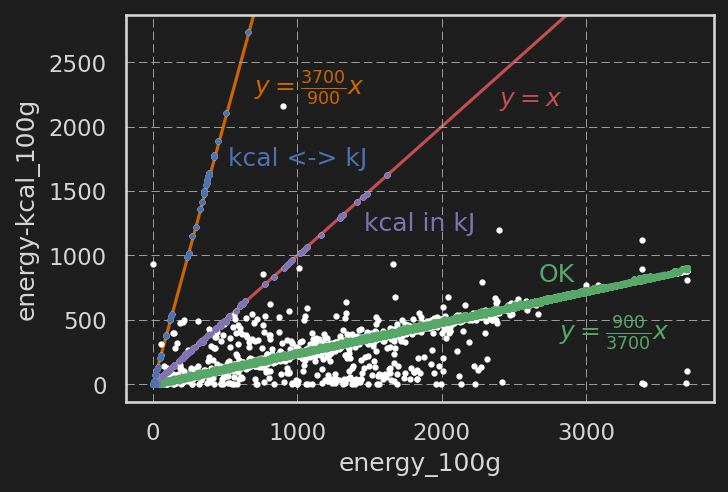

In [26]:
keys = data.keys()[ data.keys().str.contains('energy') ]
display( 'Keys linked to energy:', keys.tolist() )

for key in keys:
    sr_loc = (data[key] < 0.) | (data[key] > 3700.)
    data.loc[ sr_loc, key ] = np.nan
    data_isna.loc[ sr_loc, key ] = True

print( 'len(data):', len(data) )
print( '\nSum ~ina:')
print( (~data_isna[keys]).sum(0) )

df_croisement['energy'] = tools.croisement_NaN_counts( data_isna, keys )

print('Croisement NaN energy:')
display( df_croisement['energy'] )

wrong_1 = 'r'
wrong_2 = (0.8, 0.4, 0)
wrong_3 = (0.8, 0.7, 0)


def get_sub_sr_energy_management( x_kj, y_kcal ):
    """ get pd.Series for which energy seems : OK, kcal in kj, kcal and kj inverted, kcal > 4.5*kj """
    sr_1 = tools.distance_to_a_line( x_kj, y_kcal, 9/37, 0 )
    sr_2 = tools.distance_to_a_line( x_kj, y_kcal, 1., 0 )
    sr_3 = tools.distance_to_a_line( x_kj, y_kcal, 37/9, 0 )

    return sr_1 < 15**2, sr_2 < 15**2, sr_3 < 15**2, y > 4.5*x



X, Y = 'energy_100g', 'energy-kcal_100g'
sr_bool = ~(data_isna[X] | data_isna[Y])
x, y = data.loc[sr_bool,X], data.loc[sr_bool,Y]

sr_1, sr_2, sr_3, sr_4 = get_sub_sr_energy_management( x, y )

n_total = (~data_isna['energy_100g']).sum()
print('n ~(energy.isna | kcal.isna):', x.shape )
print('n total (~energy.isna):', n_total)
print('n OK: {:} ({:.2f}%)'.format( sr_1.sum(), sr_1.sum()/n_total*100 ) )
print('n kcal in kj: {:} ({:.2f}%)'.format(sr_2.sum(), sr_2.sum()/n_total*100) )
print('n kcal in kj inverted: {:} ({:.2f}%)'.format( sr_3.sum(), sr_3.sum()/n_total*100 ) )
print('n kcal > 4.5*kj: {:} ({:.2f}%)'.format( sr_4.sum(), sr_4.sum()/n_total*100 ) )

del n_total


# PLOT DATA
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )

ax.plot( x, y, 'wo', markersize=2)

ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout( pad=0.2 )

tools.savefig( fig, 'Figures/Energy-0.png', dpi=400)

ax.set_ylim( ax.get_ylim() )

ax.plot( [0, 3700], [0, 900], 'g--', zorder=2, label=r'$y = \frac{900}{3700} x$' )
ax.plot( [0, 3700], [0, 3700], color=wrong_1, zorder=0, label= r'$y = x$' )
ax.plot( [0, 900], [0, 3700], color=wrong_2, zorder=0, label= r'$y = \frac{3700}{900}x$' )
# ax.plot( [0, 0], [0, 900], color=wrong_3, zorder=0, label= r'$x = 0$' )
# ax.legend()
ax.annotate( r'$y = \frac{900}{3700} x$', [3200, 400], 
    va='center', ha='center', color='g' )
ax.annotate( r'$y = x$', [2400, 2200], 
    va='center', ha='left', color=wrong_1 )
ax.annotate( r'$y = \frac{3700}{900} x$', [1085, 2300], 
    va='center', ha='center', color=wrong_2 )
tools.savefig( fig, 'Figures/Energy-1.png', dpi=400)


ax.plot( x[sr_1], y[sr_1], 'go', markersize=2, label='OK')
ax.plot( x[sr_2], y[sr_2], 'mo', markersize=2, label='kcal in kj')
ax.plot( x[sr_3], y[sr_3], 'bo', markersize=2, label='kj and kcal inverted')
# ax.plot( x[sr_4], y[sr_4], 'ro', markersize=2, label='y > 4.5*x')
# lgnd = ax.legend( ncol=2, fontsize=7 )
# for handle in lgnd.KlegendHandles:
#     handle.set_markersize(6.0) # change markersize in legend

ax.annotate( 'OK', [2800, 850],
    va='center', ha='center', color='g')
ax.annotate( 'kcal in kJ', [1850, 1250],
    va='center', ha='center', color='m')
ax.annotate( 'kcal <-> kJ', [1000, 1750],
    va='center', ha='center', color='b')

tools.savefig( fig, 'Figures/Energy-2.png', dpi=400)




del sr_loc, sr_bool, sr_1, sr_2, sr_3, sr_4

## Rectification des données
Sachant que 1J = 4.184 calorie, parmis les variables "energy-kcal" et "energy" (kJ) la valeur la plus grande correspond (sauf erreur) à la valeur en kJ. La valeur conservée est donc la valeur maximale. Les valeurs en kcal sont enlevées.

In [27]:
keys = data.keys()[ data.keys().str.contains('energy') ]

sr_loc = ~(data_isna['energy_100g'] & data_isna['energy-kcal_100g'])
data.loc[ sr_loc, 'energy_100g' ] = data.loc[ sr_loc, 
                                        ['energy_100g', 'energy-kcal_100g']
                                        ].fillna( 0. ).max(1)

data['energy-kj_100g'] = data['energy_100g'].copy()
data_isna['energy-kj_100g'] = data_isna['energy_100g'].copy()

Supression des colonnes inutilisées

In [28]:
data.drop( columns=['energy-kcal_100g', 'energy_100g'] , inplace=True)
data_isna.drop( columns=['energy-kcal_100g', 'energy_100g'] , inplace=True)
print( 'keys:', data.keys().tolist() )

keys: ['code', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_en', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', '

# Filtrage par décompte des NaN et mots clefs

## Colonnes inutiles

In [29]:
sr_sum_not_isna = (~data_isna).sum(0).sort_values()
sr_drop = sr_sum_not_isna[ (sr_sum_not_isna < 0.1*len(data)) & ~(sr_sum_not_isna.index == 'index') & ~(sr_sum_not_isna.index.str.contains('level_0')) ]
print('{:} columns to drop over {:}'.format( len(sr_drop), len(sr_sum_not_isna) ) )
print('Number of NaN in columns to drop:')

with pd.option_context('display.max_rows', None):
    display( sr_drop )
#     display( sr_sum_not_isna )
data.drop( columns=sr_drop.index , inplace=True )
data_isna.drop( columns=sr_drop.index , inplace=True )
del sr_sum_not_isna, sr_drop

75 columns to drop over 108
Number of NaN in columns to drop:


nutrition-score-uk_100g                           1
chlorophyl_100g                                   1
glycemic-index_100g                               2
beta-glucan_100g                                  6
phylloquinone_100g                               10
nucleotides_100g                                 11
beta-carotene_100g                               11
carnitine_100g                                   13
omega-9-fat_100g                                 16
inositol_100g                                    17
casein_100g                                      18
serum-proteins_100g                              19
chromium_100g                                    19
molybdenum_100g                                  20
choline_100g                                     20
taurine_100g                                     31
silica_100g                                      33
ph_100g                                          42
energy-from-fat_100g                             53
insoluble-fi

## Choix des variables
Affichage des varialbes restantes

In [30]:
print(len(data.keys()))
display(data.keys())

33


Index(['code', 'last_modified_t', 'last_modified_datetime', 'product_name',
       'quantity', 'labels', 'labels_tags', 'labels_en', 'ingredients_text',
       'allergens', 'additives_n', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'ecoscore_score_fr', 'ecoscore_grade_fr', 'energy-kj_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [31]:
lst_to_drop = [ 'last_modified_t', 'last_modified_datetime',
        'quantity', 'labels', 'labels_tags', 'labels_en',
        'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
        'nova_group', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
        'nutrition-score-fr_100g', 'ecoscore_score_fr', 'ecoscore_grade_fr'
            ]

data.drop( columns=lst_to_drop, inplace=True )

In [32]:
print('keys:', data.keys().tolist())

keys: ['code', 'product_name', 'ingredients_text', 'allergens', 'additives_n', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


## Décomptes des lignes "vides"
### Affichage diagramme en barres

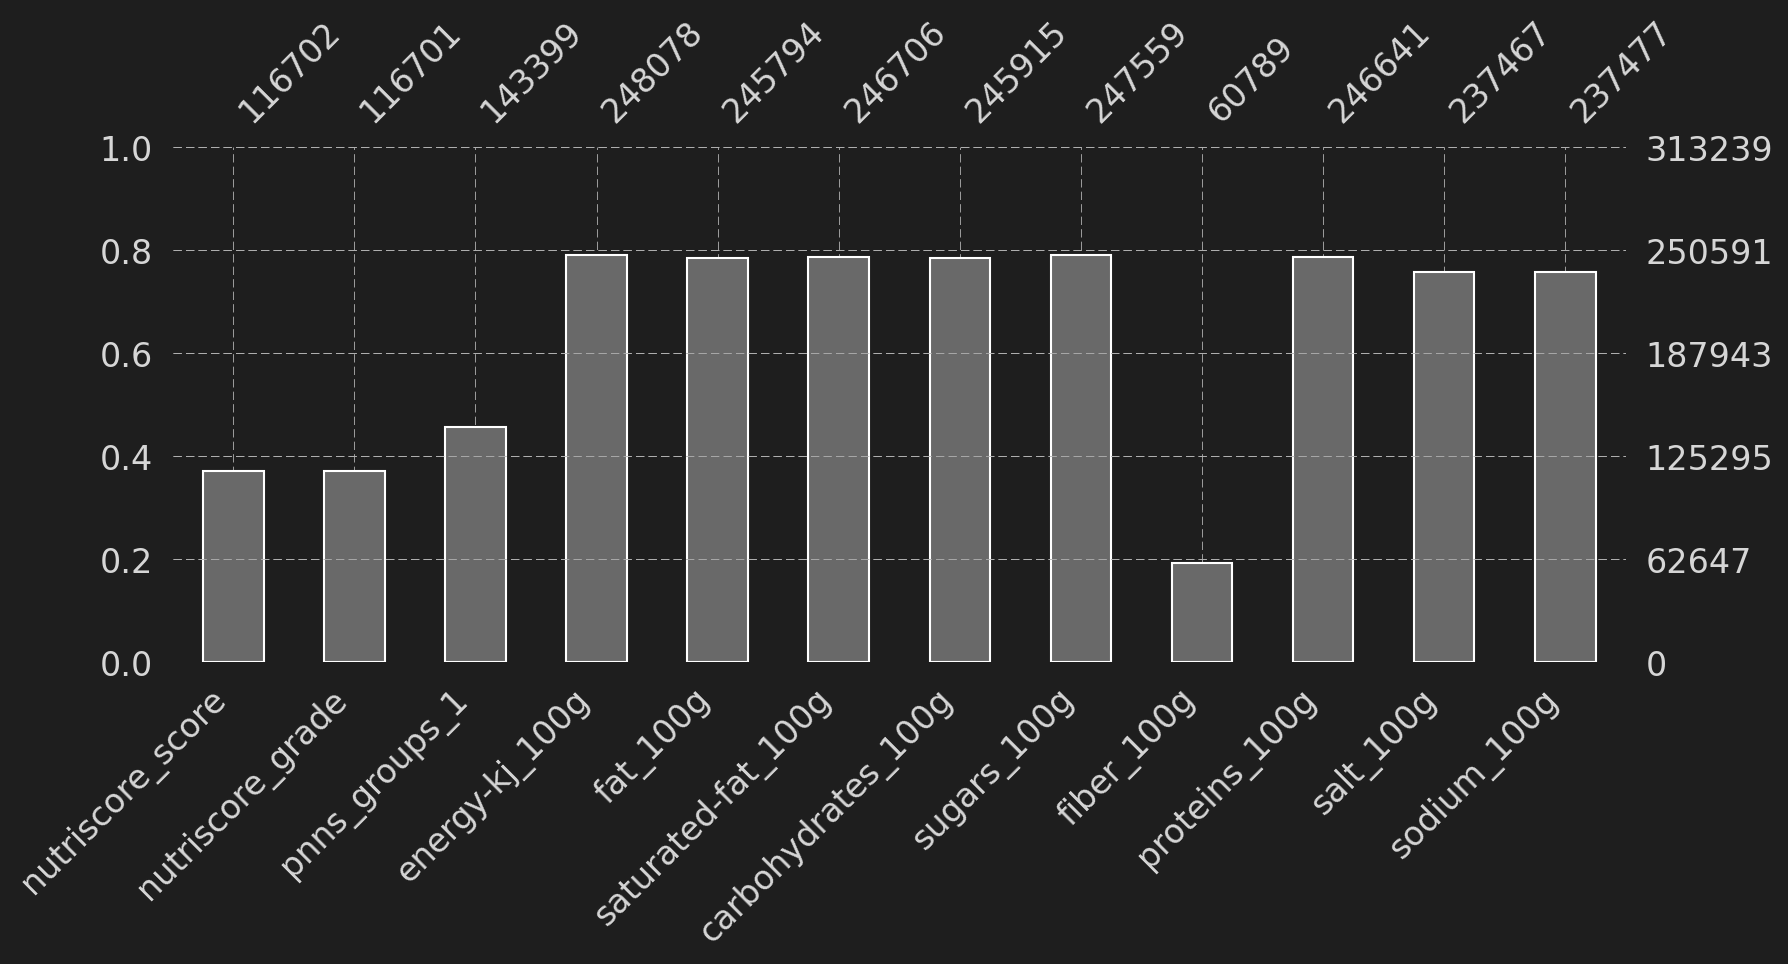

In [33]:
lst_to_hide = [ 'code', 'pnns_groups_2',
                'name','quantity', 'ingredie', 'allerg',
                'addit']
# lst_to_hide = ['code']
keys_used_0 = data.keys()[ ~data.keys().str.contains('|'.join(lst_to_hide)) ]
ax = msno.bar( data[ keys_used_0 ] )

fig = ax.get_figure()
fig.set_size_inches( (30*cm, 16*cm) )
fig.tight_layout( pad=0.2 )
tools.savefig( fig, 'Figures/bar_NaN.pdf' )

### Affichage matriciel
Affichage du remplissage des données 

keys 100g: ['nutriscore_score', 'energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


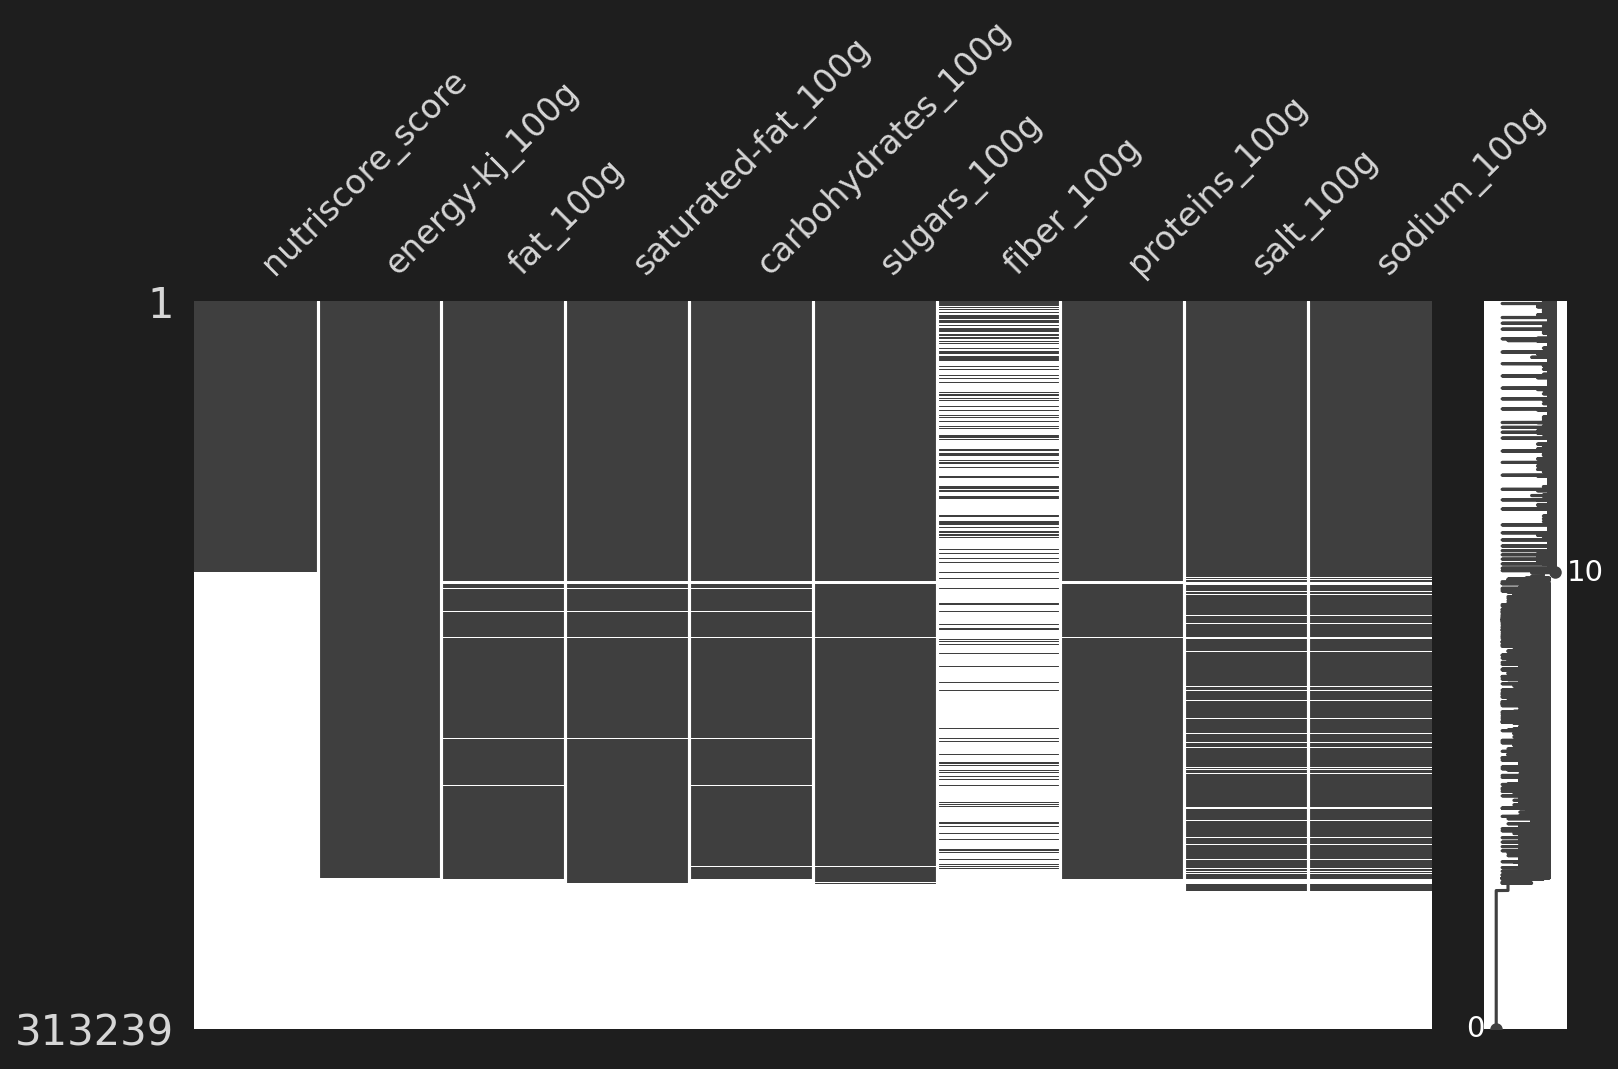

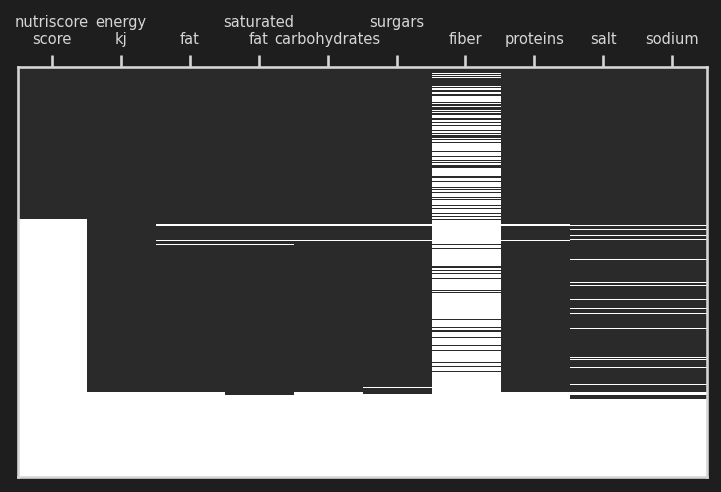

In [34]:
keys_100g = pd.Series( keys_used_0[ keys_used_0.str.contains('_100g|nutriscore_score') ] )
print( 'keys 100g:', keys_100g.tolist() )
ax = msno.matrix( data[keys_100g].sort_values( by=keys_100g.tolist()) )


fig = ax.get_figure()
fig.set_size_inches( (30*cm, 16*cm) )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
I = data[keys_100g].sort_values( by=keys_100g.tolist()).isna()
ax.imshow( I, cmap='gray', vmin=-0.2, vmax=1, interpolation='nearest' )
ax.axis('auto')
ax.set_yticks( [] )
ax.set_xticks( range(len(keys_100g)))
ax.set_xticklabels( [key.replace('_100g','').replace('_','\n').replace('-','\n').replace('sugars','surgars\n') for key in keys_100g], fontdict={'size':7})
ax.xaxis.set_ticks_position('top')
ax.grid( visible=False )
fig.tight_layout( pad=0.2 )
# fig.set_alpha(1.)
tools.savefig( fig, 'Figures/matrix_NaN.pdf' )

Quelques NaN éparses sont visibles, mais pour la majeur partie des NaN sont sur toute la ligne.
Le plus sain est donc d'enlever les lignes pour lequelles toutes les valeurs sont NaN.

Les lignes avec trop peux d'élements sont aussi enlevées.

66386 rows dropped on 313239


/tmp/ipykernel_9776/4249943593.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout( pad=0.2 )


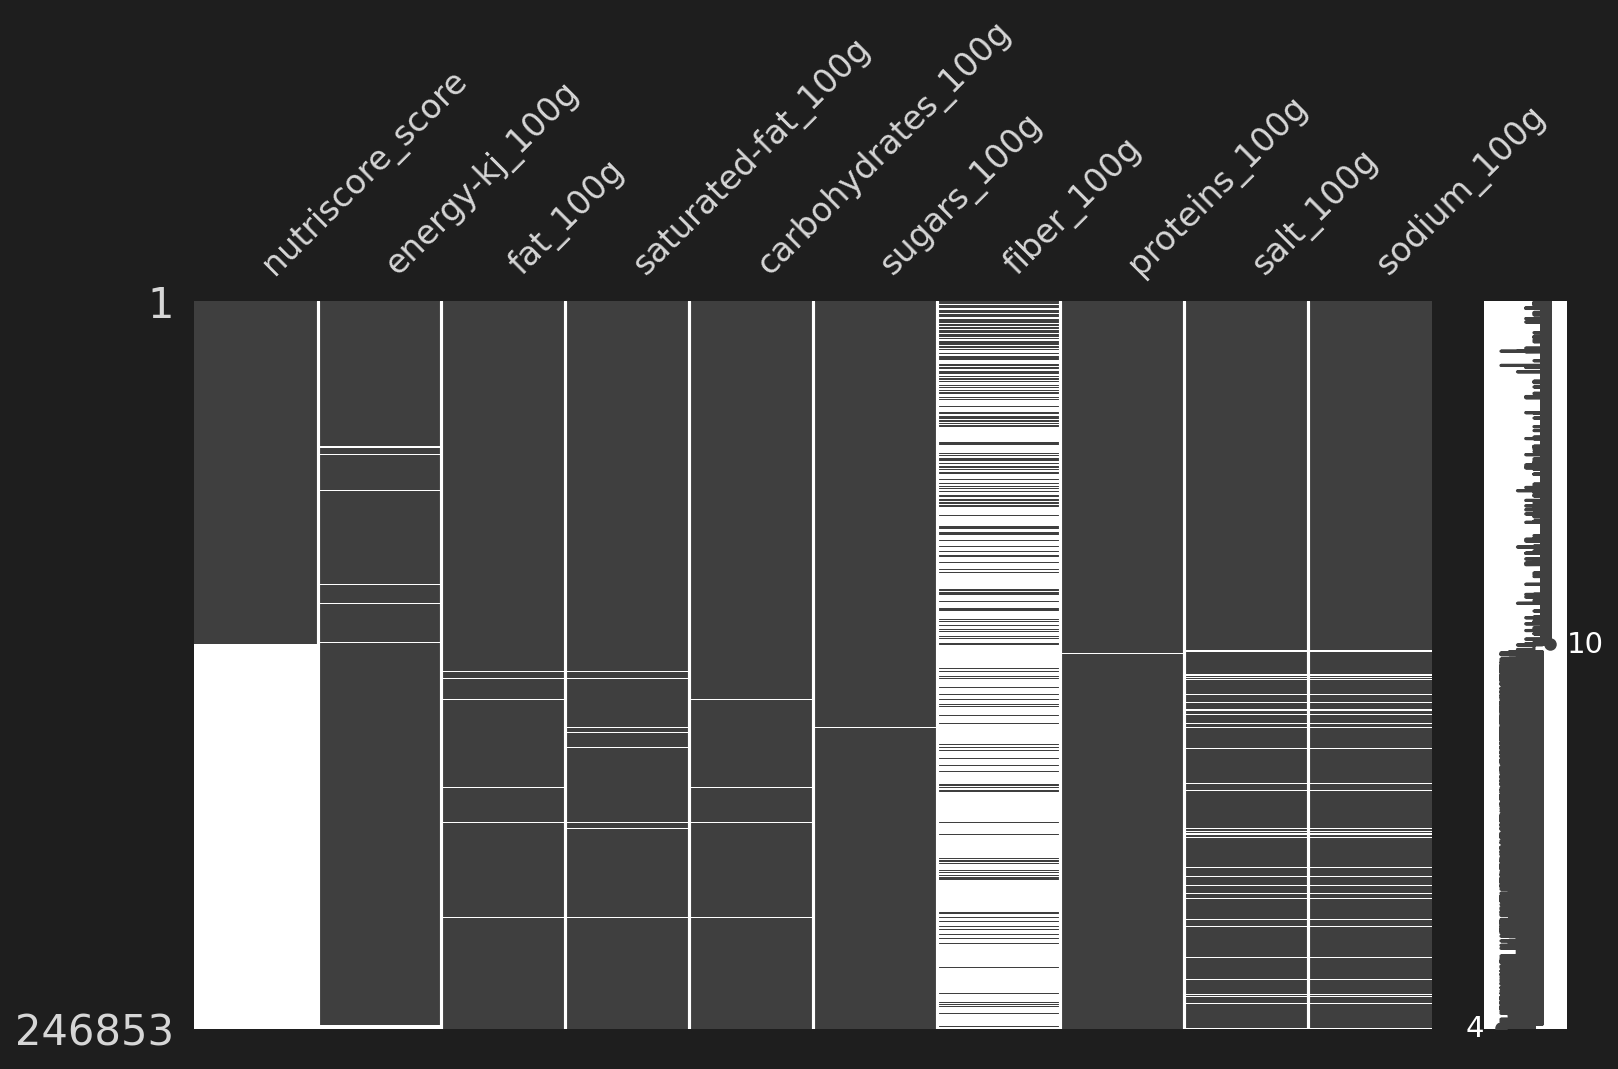

In [237]:
sr_loc = data[keys_100g].isna().sum(1) > (len(keys_100g) - 4 )

print('{:} rows dropped on {:}'.format( sr_loc.sum() , len(sr_loc) ))

data.drop( index = sr_loc[sr_loc].index , inplace=True )
ax = msno.matrix( data[keys_100g].sort_values( by=keys_100g.tolist()) )

fig = ax.get_figure()
fig.set_size_inches( (30*cm, 16*cm) )
fig.tight_layout( pad=0.2 )
tools.savefig( fig, 'Figures/matrix_NaN_2.pdf' )

## Fibres NaN -> 0
Pour les fibres, vu la proportion et le fait qu'habituellement sur les emballage cette information n'est pas données si la valeur vaut 0, les valeurs NaN sont remplacées par des 0.

In [238]:
data['fiber_100g'].fillna(0., inplace=True)

## Uniquement valeurs == 0
Les lignes ne contenant que des valeurs égales à 0. (ou NaN) sont enlevées.

In [239]:
sr_loc = data[keys_100g].max(1)==0
print('n max(row) == 0 : {:} over {:} rows'.format( sr_loc.sum(), len(sr_loc)) )
data.drop( index= sr_loc[sr_loc].index, inplace=True )

n max(row) == 0 : 2828 over 246853 rows


# SAVE DATA

In [240]:
print('data shape:', data.shape)
print('columns:', data.keys().tolist())

data shape: (244025, 20)
columns: ['code', 'product_name', 'ingredients_text', 'allergens', 'additives_n', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


In [241]:
# changement en type category pour optimiser la mémoire
data['pnns_groups_1'] = data['pnns_groups_1'].astype('category')
data['nutriscore_grade'] = data['nutriscore_grade'].astype('category')

data.to_pickle( 'data_clean.pkl')